# 3 Unsupervised Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import tensor
from torch.optim import Adam
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

## Question 3

### I

**Load Task2C_labeled.csv, Task2C_unlabeled.csv, and Task2C_test.csv datasets, along with the required libraries. Note that we will use both Task2C_labeled.csv and Task2C_unlabeled.csv to train the autoencoder, and only Task2C_labeled.csv to train the classifiers. Finally, we will evaluate the trained classifier on the test dataset Task2C_test.csv.**

In [2]:
# Load the dataset
labeled_dataset = pd.read_csv('Task2C_labeled.csv')
unlabeled_dataset = pd.read_csv('Task2C_unlabeled.csv')
test_dataset = pd.read_csv('Task2C_test.csv')

In [3]:
# Training data for the autoencoder
X = pd.concat([labeled_dataset.iloc[:, 1:], unlabeled_dataset], axis=0)

# Training and test data for the classifier
X_train = np.array(labeled_dataset.iloc[:,1:])
y_train = np.array(labeled_dataset.iloc[:,0])
X_test = np.array(test_dataset.iloc[:,1:])
y_test = np.array(test_dataset.iloc[:,0])

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).long()

### II

**Train an autoencoder with only one hidden layer and change the number of its neurons to 20, 60, 100, ..., 220 (i.e. from 20 to 220 with a step size of 40).**

In [4]:
def normalize(x, m=None, s=None): 
    if m is None or s is None:
        #print('Normalizing data: No mean and/or sd given. Assuming it is training data')
        m,s = x.mean(), x.std()
        
    return (x-m)/s

In [5]:
def get_dataloader(X_train,Y_train=None, autoencoder=False,bs=128, standardize=True, return_dataset=False):
    """
    Retrieves a data loader to use for training. In case autoencoder=True, Y_train automatically is set to X_train
    The function returns the dataloader only if return_dataset is False otherwise it returns a tuple (dataloader,train_dataset)
    where train_dataset is the Dataset object after preprocessing.
    """
    try:
        X_train= np.array(X_train).astype(np.float32)
        if standardize: X_train = normalize(X_train)
        if not autoencoder: Y_train = np.array(Y_train)
    except Exception as e:
        raise Exception('Make sure your input and labels are array-likes. Your input failed with exception: %s'%e)
    # transform into tensors
    if autoencoder:
        Y_train = X_train
    
    X_train, Y_train = map(tensor, (X_train, Y_train))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
            
    train_ds = TensorDataset(X_train,Y_train)
    train_dl = DataLoader(train_ds, batch_size=16)
    
    if return_dataset: return train_dl,train_ds
    
    return train_dl

In [6]:
def train_autoencoder(X_train,hidden,activation='Tanh',epochs=10, trace=True, **kwargs):
    """
    Trains an Autoencoder and returns the trained model
    
    Params:
    X_train: Input data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    
    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers
    
    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    
    epochs: Number of epochs to train autoencoder
    
    trace: if true, will display epoch progress and will plot the loss plot at the end of training
    
    **kwargs: passed to Adam optimizer, lookup adam optimizer for more details
    """
    train_dl = get_dataloader(X_train,autoencoder=True)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = n_inps
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')
        
    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])
    
    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
    # to capture training loss
    losses = []
    epoch_losses = []
    # define optimizer with learning rate
    optim = Adam(model.parameters(), **kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.MSELoss()
    # calculate printing step - optional
    printing_step = int(epochs/10)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optim.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        if trace and not epoch%printing_step:
            print(f'Epoch {epoch} out of {epochs}. Loss:{epoch_loss}')

    return model, epoch_losses

In [7]:
hidden_layer_sizes = np.arange(20, 260, 40)

# Save the models for visualization and Step V
models = []

# Train the autoencoder
for hidden_size in hidden_layer_sizes:
    print(f'Training autoencoder with hidden layer size: {hidden_size}')
    model, _ = train_autoencoder(
        X_train = X, # training data
        hidden = [hidden_size], # number of layers and their units
        epochs = 50, # maximum number of epoches  
        activation = 'ReLU', # activation function
        lr = 0.0001,   #learning rate
        trace=False
    )
    models.append(model)

Training autoencoder with hidden layer size: 20
Training autoencoder with hidden layer size: 60
Training autoencoder with hidden layer size: 100
Training autoencoder with hidden layer size: 140
Training autoencoder with hidden layer size: 180
Training autoencoder with hidden layer size: 220


### III

**For each model in Step II, calculate and record the reconstruction error for the autoencoder, which is simply the average of Euclidean distances between the input and output of the autoencoder. Plot these values where the x-axis is the number of units in the middle layer and the y-axis is the reconstruction error. Then, explain your findings based on the plot.**

In [8]:
def calculate_reconstruction_error(model, X_train):
    model.eval()
    with torch.no_grad():
        X_train = X_train.to_numpy()
        # Training used normalize
        X_train = normalize(X_train)
        X_train = torch.Tensor(X_train)
        preds = model(X_train)
        # average of Euclidean distances between the input and output of the autoencoder
        error = torch.norm(X_train - preds, p=2, dim=1).mean().item()
    return error

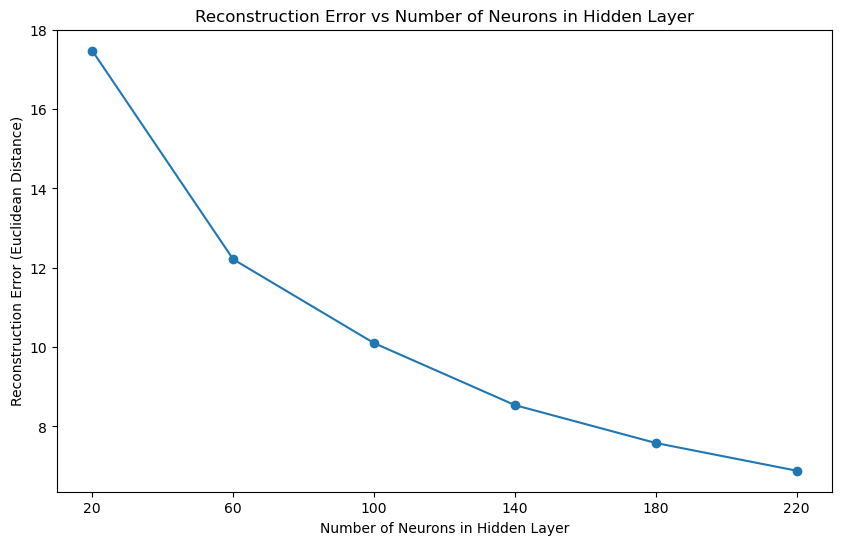

In [9]:
reconstruction_errors = []

for model in models:
    # Compute and record the reconstruction error
    error = calculate_reconstruction_error(model, X)
    reconstruction_errors.append(error)

# Plot reconstruction error
plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_sizes, reconstruction_errors, marker='o')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Reconstruction Error (Euclidean Distance)')
plt.title('Reconstruction Error vs Number of Neurons in Hidden Layer')
plt.xticks(hidden_layer_sizes)
plt.show()

1. As the number of neurons in the hidden layer increases, the reconstruction error decreases. This indicates that the autoencoder is better able to capture the underlying structure of the data as the model capacity increases (i.e., as more neurons are added to the hidden layer).
2. Initially, there is sharp decrease in reconstruction error as the number of neurons increases from 20 to 60. After this, the rate of error reduction slows down. This suggests that while increasing the number of neurons significantly improves performance at first, the benefits start to weaken after a certain point.
3. As the number of neurons increases beyond a certain point (e.g., 180-220), the decrease in reconstruction error becomes very small. This could indicate that the autoencoder might be approaching a point where adding more neurons will not lead to significantly improvements in performance, and might even risk overfitting if continued.

### IV

**Build the 3-layer NN to build a classification model using all the original attributes from the training set and change the number of its neurons to 20, 60, 100, ..., 220 (i.e. from 20 to 220 with a step size of 40). For each model, calculate and record the test error.**

In [10]:
def train_classifier(X_train,Y_train,hidden,activation='Tanh',epochs=10, trace=True,**kwargs):
    """
    Trains a feedforward classifier and returns the trained model
    
    Params:
    X_train: Training data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    
    Y_train: Training labels. Can be a Series, 1D numpy array, 1-D list or a tensor with 1 dimension
    
    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers
    
    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    
    epochs: Number of epochs to train autoencoder
    
    trace: if true, will display epoch progress and will plot the loss plot at the end of training
    """
    train_dl = get_dataloader(X_train,Y_train,autoencoder=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = [len(Y_train.unique())]   # is not a good idea if you are expecting very large datasets
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')
        
    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])
    
    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
    # to capture training loss
    losses = []
    epoch_losses =[]
    # define optimizer with learning rate
    optim = Adam(model.parameters(),**kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.CrossEntropyLoss()
    # calculate printing step - optional
    printing_step = int(epochs/10)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optim.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        if trace and not epoch%printing_step:
            print(f'Epoch {epoch} out of {epochs}. Loss:{epoch_loss}')

    return model, epoch_losses

In [11]:
hidden_layer_sizes = np.arange(20, 260, 40)
# Save the test errors for visualization in Step VI
test_errors_cls = []
# Error metric
criterion = nn.CrossEntropyLoss()

# Train the classifier
for hidden_size in hidden_layer_sizes:
    print(f'Training model with hidden layer size: {hidden_size}', end='\t')

    model, _ = train_classifier(
        X_train=X_train,
        Y_train=y_train,
        hidden=[hidden_size],
        activation='ReLU',
        epochs=50,
        trace=False,
        lr=0.0001
    )

    model.eval()

    # Calculate and record the test error
    with torch.no_grad():
        preds = model(normalize(X_test))
        test_loss = criterion(preds, y_test).item()
        print(f'Test Error: {test_loss:.4f}')
        test_errors_cls.append(test_loss)

Training model with hidden layer size: 20	Test Error: 1.6321
Training model with hidden layer size: 60	Test Error: 1.4859
Training model with hidden layer size: 100	Test Error: 1.3062
Training model with hidden layer size: 140	Test Error: 1.2595
Training model with hidden layer size: 180	Test Error: 1.2118
Training model with hidden layer size: 220	Test Error: 1.1795


### V

**Build augmented self-taught networks using the models learnt in Step II. For each model:**

**1\) Add the output of the middle layer of an autoencoder as extra features to the original feature set;**

**2\) Train a new 3-layer Neural Network using all features (original + extra) and varying the number of hidden neurons (like Step IV) as well.**

**3\) Then calculate and record the test error.**

**For example, each model should be developed as follows: Model 1: 20 hidden neurons + extra 20 features (from an autoencoder), Model 2: 60 hidden neurons + extra 60 features (from an autoencoder), ..., Model 5: 220 hidden neurons + extra 220 features (from an autoencoder).**

In [12]:
def get_deepfeatures(trained_model, X_input,layer_number):
    '''
    Gets deep features of a given `layer_number` upon passing `X_input` through a `trained_model`   
    '''
    X_input = get_dataloader(X_input,autoencoder=True,return_dataset=True)[1].tensors[0]
    result = []
    def save_result(m,i,o):
        result.append(o.data)
    hook = trained_model[layer_number].register_forward_hook(save_result)

    with torch.no_grad():
        trained_model(X_input)

    hook.remove()
    
    return (result[0].cpu().numpy())

In [13]:
hidden_layer_sizes = np.arange(20, 260, 40)
# Save the test errors for visualization in Step VI
test_errors_extra = []
# Error metric
criterion = nn.CrossEntropyLoss()

for i, model in enumerate(models): # Use the models learnt in Step II
    print(f'Testing model with hidden layer size: {hidden_layer_sizes[i]}', end='\t')
    
    # the output of the middle layer of the autoencoder
    extra_train_features = get_deepfeatures(model, X_train, layer_number=1) # middle layer
    extra_test_features = get_deepfeatures(model, X_test, layer_number=1)
    
    # Add extra features to the original feature set
    augmented_X_train = np.hstack((X_train, extra_train_features))
    augmented_X_test = np.hstack((X_test, extra_test_features))
    
    # Train the augmented self-taught networks
    cls_model, _ = train_classifier(
        X_train=augmented_X_train,
        Y_train=y_train,
        hidden=[hidden_layer_sizes[i]],
        activation='ReLU',
        epochs=50,
        trace=False,
        lr=0.0001
    )

    # Calculate and record the test error
    cls_model.eval()
    with torch.no_grad():
        augmented_X_test = normalize(augmented_X_test)
        augmented_X_test = torch.Tensor(augmented_X_test)
        preds = cls_model(augmented_X_test)
        test_loss = criterion(preds, y_test)
        print(f'Test Error: {test_loss:.4f}')
        test_errors_extra.append(test_loss)

Testing model with hidden layer size: 20	Test Error: 1.8583
Testing model with hidden layer size: 60	Test Error: 1.4003
Testing model with hidden layer size: 100	Test Error: 1.3121
Testing model with hidden layer size: 140	Test Error: 1.1970
Testing model with hidden layer size: 180	Test Error: 1.1858
Testing model with hidden layer size: 220	Test Error: 1.1804


### VI

**Plot the error rates for the 3-layer neural networks from Step IV and the augmented self-taught networks from Step V, while the x-axis is the number of hidden neurons and y-axis is the classification error. Explain how the performance of the 3-layer neural networks and the augmented self-taught networks is different and why they are different or why they are not different, based on the plot.**

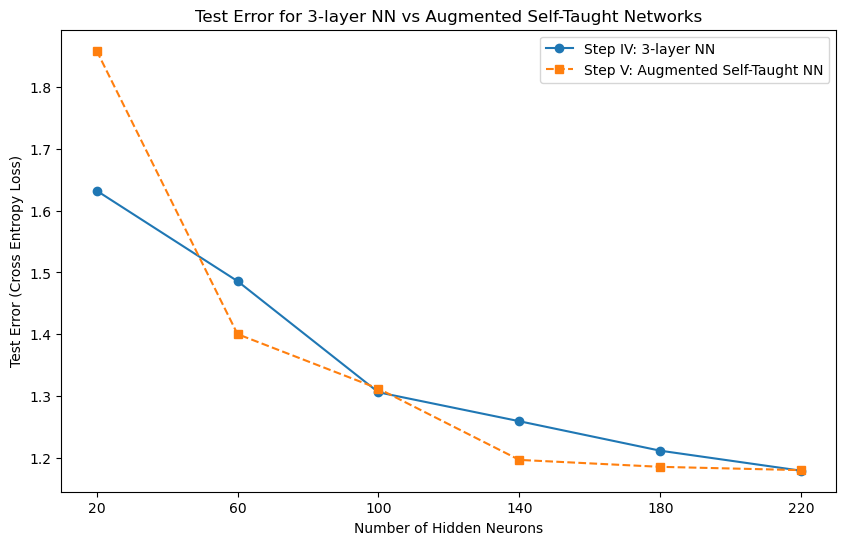

In [14]:
hidden_layer_sizes = np.arange(20, 260, 40)

plt.figure(figsize=(10, 6))

# Test error from Step IV
plt.plot(hidden_layer_sizes, test_errors_cls, label='Step IV: 3-layer NN', marker='o', linestyle='-')

# Test error from Step V
plt.plot(hidden_layer_sizes, test_errors_extra, label='Step V: Augmented Self-Taught NN', marker='s', linestyle='--')

plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Test Error (Cross Entropy Loss)')
plt.title('Test Error for 3-layer NN vs Augmented Self-Taught Networks')

plt.xticks(hidden_layer_sizes)
plt.legend()
plt.show()

1. Performance differences:
- The augmented self-taught networks consistently show a slightly lower error compared to the 3-layer neural networks for most hidden layer sizes, except at the beginning (hidden neurons = 20).
- As the number of hidden neurons increases, both networks show a decreasing trend in test error.
- For larger hidden layer sizes (e.g., 180 and 220 neurons), the test errors for both models converge, with the augmented networks having a marginally better performance.

2. Reasons for the differences:
- The augmented self-taught networks utilize extra features from the autoencoder's middle layer (learned through both labeled and unlabeled data). This additional information helps the model learn a richer representation of the data, resulting in improved performance.
- By using both labeled and unlabeled data in the autoencoder pretraining step, the augmented network can learn a more generalized feature space, which helps reduce the test error in comparison to the standard 3-layer neural network that only uses the original features.
- The augmented self-taught networks have more feature dimensions (original + autoencoder features), which might provide more useful information for classification. This is particularly useful when the hidden layer is smaller, as the network may not have enough neurons to extract complex patterns from the original features.

3. Why the differences diminish at larger sizes:
- As the number of hidden neurons increases, both networks become more capable of learning the underlying patterns in the data. The additional information from the autoencoder might not provide as significant a benefit when the model already has a larger capacity to learn from the data.
- When the hidden layer becomes sufficiently large (180-220 neurons), the benefit of adding extra features from the autoencoder diminishes because the network is already able to learn rich representations from the original features. This is why the test errors for both models converge at the higher end.

Conclusion:
The augmented self-taught networks outperform the standard 3-layer neural networks for smaller hidden layer sizes, likely due to the extra features from the autoencoder providing more informative inputs. However, as the hidden layer size increases, the difference between the two models diminishes, with both converging to similar error rates when the number of neurons is large enough to capture the underlying structure of the data independently.